In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#importing the necessary libraries

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data() 

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


Taking the dataset only for Ship and Airplane

In [12]:
y_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
index_1,index_2 = y_classes.index("airplane"), y_classes.index("ship")

X_train_airplane = X_train[(y_train == index_1).ravel()][:]
X_test_airplane = X_test[(y_test == index_1).ravel()][:]
X_train_ship = X_train[(y_train == index_2).ravel()][:]
X_test_ship = X_test[(y_test == index_2).ravel()][:]


Few examples for the Ship and Airplane Dataset

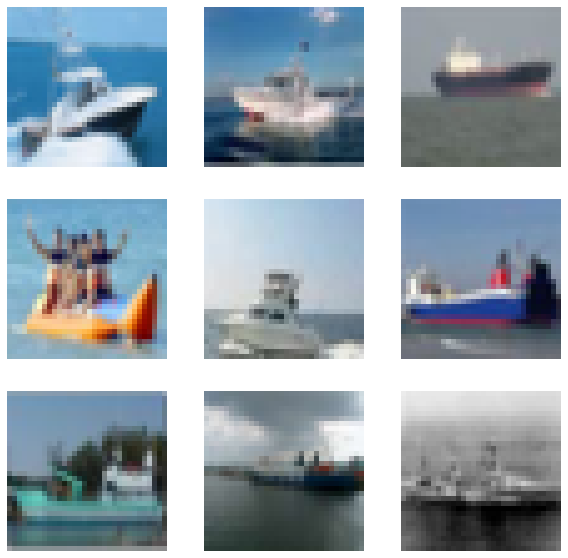

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train_ship[i])
  plt.axis("off")

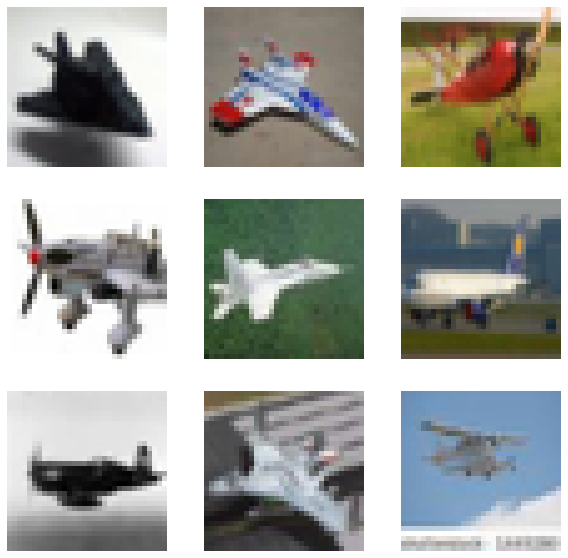

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train_airplane[i])
  plt.axis("off")